In [1]:
import sys

sys.path.append("../")
import pandas as pd
from config.settings import MONGO_CONNECTION_STRING
from pymongo import MongoClient

In [2]:
client = MongoClient(
    MONGO_CONNECTION_STRING,
    tls=True,
    tlsAllowInvalidCertificates=True,  # For development only
    # tlsCAFile='/Users/tyrelle/Desktop/4ex.ninja/4ex.ninja/config/global-bundle.pem'
)

In [3]:
db = client["forex_data"]
collections = db.list_collection_names()

In [4]:
# Choose a collection (for example GBP_JPY_H4)
collection_name = "GBP_JPY_H4"
collection = db[collection_name]

# Fetch all documents and convert to DataFrame
df_GBPJPY_H4 = pd.DataFrame(list(collection.find()))

# Set the time column as the index
df_GBPJPY_H4.set_index("time", inplace=True)

# Extract OHLC values from the mid dictionary
df_GBPJPY_H4["open"] = df_GBPJPY_H4["mid"].apply(lambda x: float(x["o"]))
df_GBPJPY_H4["high"] = df_GBPJPY_H4["mid"].apply(lambda x: float(x["h"]))
df_GBPJPY_H4["low"] = df_GBPJPY_H4["mid"].apply(lambda x: float(x["l"]))
df_GBPJPY_H4["close"] = df_GBPJPY_H4["mid"].apply(lambda x: float(x["c"]))

# Drop unnecessary columns and reorder
df_GBPJPY_H4 = df_GBPJPY_H4[["volume", "open", "high", "low", "close"]]

# Display information about the data
print(f"\nDataFrame info for {collection_name}:")
print(f"Total number of candles: {len(df_GBPJPY_H4)}")
print("\nFirst few rows:")
print(df_GBPJPY_H4.head())


DataFrame info for GBP_JPY_H4:
Total number of candles: 15557

First few rows:
                     volume     open     high      low    close
time                                                           
2015-02-16 02:00:00   14990  182.850  183.058  182.681  182.914
2015-02-16 06:00:00   23100  182.913  183.222  182.615  182.638
2015-02-16 10:00:00   18734  182.637  182.674  182.046  182.180
2015-02-16 14:00:00   23632  182.180  182.326  181.636  181.746
2015-02-16 18:00:00   29215  181.746  182.064  181.534  182.010


In [30]:
import numpy as np

# from config.settings import ma_pairs


def identify_multiple_ma_crossovers(df, ma_pairs):
    """
    Identify MA crossover signals for multiple MA combinations

    Parameters:
    df : pandas DataFrame with price data
    ma_pairs : list of tuples, each containing (fast_period, slow_period)

    Returns:
    DataFrame with signals for each MA combination
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()

    # Calculate all required MAs
    for fast, slow in ma_pairs:
        df[f"SMA_{fast}"] = df["close"].rolling(window=fast).mean()
        df[f"SMA_{slow}"] = df["close"].rolling(window=slow).mean()

        # Generate signals for this MA pair
        signal_col = f"signal_{fast}_{slow}"
        df[signal_col] = np.where(
            (df[f"SMA_{fast}"] > df[f"SMA_{slow}"])
            & (df[f"SMA_{fast}"].shift(1) <= df[f"SMA_{slow}"].shift(1)),
            1,  # Buy signal
            np.where(
                (df[f"SMA_{fast}"] < df[f"SMA_{slow}"])
                & (df[f"SMA_{fast}"].shift(1) >= df[f"SMA_{slow}"].shift(1)),
                -1,  # Sell signal
                0,  # No signal
            ),
        )

    return df


ma_pairs = [(180, 50), (170, 50), (200, 50), (10, 80), (10, 70)]


# Apply to your DataFrame
df_with_signals = identify_multiple_ma_crossovers(df_GBPJPY_H4, ma_pairs)

# Print columns with signals
signal_columns = [col for col in df_with_signals.columns if col.startswith("signal_")]
print("\nSignal columns created:")
for col in signal_columns:
    print(f"- {col}")

# Example: Count signals for each MA pair
for col in signal_columns:
    buy_signals = (df_with_signals[col] == 1).sum()
    sell_signals = (df_with_signals[col] == -1).sum()
    print(f"\n{col}:")
    print(f"Buy signals: {buy_signals}")
    print(f"Sell signals: {sell_signals}")


Signal columns created:
- signal_180_50
- signal_170_50
- signal_200_50
- signal_10_80
- signal_10_70

signal_180_50:
Buy signals: 53
Sell signals: 53

signal_170_50:
Buy signals: 54
Sell signals: 54

signal_200_50:
Buy signals: 50
Sell signals: 50

signal_10_80:
Buy signals: 142
Sell signals: 141

signal_10_70:
Buy signals: 162
Sell signals: 162


In [17]:
def calculate_pip_value(symbol: str, price_change: float) -> float:
    """Calculate pip value based on currency pair"""
    if 'JPY' in symbol:
        return price_change * 100  # JPY pairs move in 0.01 increments
    else:
        return price_change * 10000  # Other pairs move in 0.0001 increments

def backtest_multiple_signals(df, signal_columns, symbol):
    """
    Backtest trades based on multiple MA crossover signals.
    Returns a dictionary of results for each MA combination.
    Accounts for different pip calculations based on currency pair.
    """
    results = {}

    for signal_col in signal_columns:
        trades = []
        open_trade = None
        df_temp = df.copy()

        for time, row in df_temp.iterrows():
            signal = row[signal_col]
            price = row["close"]

            if signal != 0:
                if open_trade is None:
                    open_trade = {
                        "entry_time": time,
                        "entry_price": price,
                        "signal": signal,
                    }
                elif signal != open_trade["signal"]:
                    exit_price = price
                    exit_time = time
                    price_change = (exit_price - open_trade["entry_price"]) if open_trade["signal"] == 1 else (open_trade["entry_price"] - exit_price)
                    pip_gain = calculate_pip_value(symbol, price_change)

                    trade = {
                        "entry_time": open_trade["entry_time"],
                        "exit_time": exit_time,
                        "entry_price": open_trade["entry_price"],
                        "exit_price": exit_price,
                        "signal": open_trade["signal"],
                        "pip_gain": pip_gain,
                    }
                    trades.append(trade)
                    open_trade = {
                        "entry_time": time,
                        "entry_price": price,
                        "signal": signal,
                    }

        # Handle open trade at end of data
        if open_trade is not None:
            last_time = df_temp.index[-1]
            last_price = df_temp.iloc[-1]["close"]
            price_change = (last_price - open_trade["entry_price"]) if open_trade["signal"] == 1 else (open_trade["entry_price"] - last_price)
            pip_gain = calculate_pip_value(symbol, price_change)
            
            trade = {
                "entry_time": open_trade["entry_time"],
                "exit_time": last_time,
                "entry_price": open_trade["entry_price"],
                "exit_price": last_price,
                "signal": open_trade["signal"],
                "pip_gain": pip_gain,
            }
            trades.append(trade)

        # Calculate and store results
        if trades:
            trades_df = pd.DataFrame(trades)
            total_pips = trades_df["pip_gain"].sum()
            num_trades = len(trades_df)
            avg_pips = trades_df["pip_gain"].mean()
            win_rate = (trades_df["pip_gain"] > 0).mean()

            results[signal_col] = {
                "trades": trades_df,
                "total_pips": total_pips,
                "num_trades": num_trades,
                "avg_pips": avg_pips,
                "win_rate": win_rate,
            }

    return results

In [18]:
# Run backtest for all MA combinations
results = backtest_multiple_signals(df_with_signals, signal_columns, symbol="GBPJPY")

# Print summary of results for each MA combination
print("\nBacktest Results Summary:")
print("-" * 80)
summary_data = []
for ma_combo, result in results.items():
    summary_data.append(
        {
            "MA_Combo": ma_combo,
            "Total_Trades": result["num_trades"],
            "Total_Pips": round(result["total_pips"], 1),
            "Avg_Pips": round(result["avg_pips"], 1),
            "Win_Rate": f"{result['win_rate']*100:.1f}%",
        }
    )

# Convert to DataFrame for better visualization
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("Total_Pips", ascending=False)
print(summary_df)


Backtest Results Summary:
--------------------------------------------------------------------------------
        MA_Combo  Total_Trades  Total_Pips  Avg_Pips Win_Rate
3   signal_10_80           283     12417.2      43.9    36.7%
0  signal_180_50           106      8286.2      78.2    69.8%
1  signal_170_50           108      7505.0      69.5    67.6%
2  signal_200_50           100      6404.2      64.0    68.0%


In [19]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Convert to DataFrame and sort
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("Total_Pips", ascending=False)

# Display full results
print(summary_df)

# Optional: Reset display options to default after viewing
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.float_format')

        MA_Combo  Total_Trades  Total_Pips  Avg_Pips Win_Rate
3   signal_10_80           283    12417.20     43.90    36.7%
0  signal_180_50           106     8286.20     78.20    69.8%
1  signal_170_50           108     7505.00     69.50    67.6%
2  signal_200_50           100     6404.20     64.00    68.0%


In [20]:
def calculate_atr(df, period=14):
    """
    Calculate Average True Range (ATR)

    Parameters:
    - df: DataFrame with high, low, close prices
    - period: Period for ATR calculation, default 14

    Returns:
    - Series containing ATR values
    """
    df = df.copy()

    # Calculate True Range
    df["tr1"] = df["high"] - df["low"]
    df["tr2"] = abs(df["high"] - df["close"].shift(1))
    df["tr3"] = abs(df["low"] - df["close"].shift(1))

    df["tr"] = df[["tr1", "tr2", "tr3"]].max(axis=1)

    # Calculate ATR
    atr = df["tr"].rolling(window=period).mean()

    return atr


Realistic Backtest Results:
Total Trades: 323
Total Pips: 3420.8
Average Pips per Trade: 10.6
Win Rate: 44.9%
Sharpe Ratio: 3.24

Exit Analysis:
----------------------------------------
Exit Type Distribution:
sl: 178 trades (0.0% win rate)
tp: 144 trades (100.0% win rate)

Risk Metrics:
----------------------------------------
Profit Factor: 1.66
Maximum Drawdown: 298.7 pips
------------------------------------------------------------


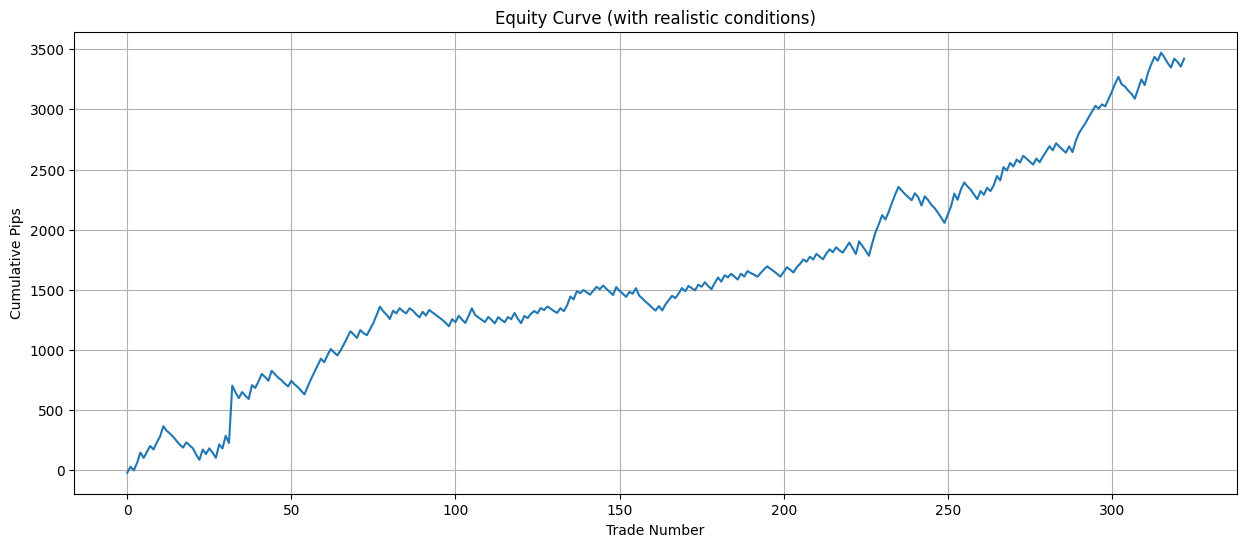

In [31]:
# Import plotting library
import matplotlib.pyplot as plt


def realistic_backtest_with_risk_management(
    df, signal_col, symbol, spread_pips=1.0, tp_atr=1.0, sl_atr=0.5, atr_period=14
):
    """
    Add ATR-based stops and targets to realistic backtest with JPY pair support
    """

    def calculate_pip_value(price_change: float) -> float:
        """Calculate pip value based on currency pair"""
        if "JPY" in symbol:
            return price_change * 100  # JPY pairs move in 0.01 increments
        return price_change * 10000  # Other pairs move in 0.0001 increments

    def calculate_spread_adjustment(spread_pips: float) -> float:
        """Calculate spread adjustment based on pair type"""
        if "JPY" in symbol:
            return spread_pips * 0.01  # JPY pairs
        return spread_pips * 0.0001  # Other pairs

    df = df.copy()
    df["atr"] = calculate_atr(df, atr_period)
    trades = []
    open_trade = None
    spread_adj = calculate_spread_adjustment(spread_pips)

    for i in range(len(df) - 1):
        current_row = df.iloc[i]
        next_row = df.iloc[i + 1]

        signal = current_row[signal_col]
        current_atr = current_row["atr"]

        if open_trade is not None:
            if open_trade["signal"] == 1:
                take_profit = open_trade["entry_price"] + (current_atr * tp_atr)
                stop_loss = open_trade["entry_price"] - (current_atr * sl_atr)
                if next_row["high"] >= take_profit:
                    exit_price = take_profit
                    exit_type = "tp"
                elif next_row["low"] <= stop_loss:
                    exit_price = stop_loss
                    exit_type = "sl"
                else:
                    continue
            else:
                take_profit = open_trade["entry_price"] - (current_atr * tp_atr)
                stop_loss = open_trade["entry_price"] + (current_atr * sl_atr)
                if next_row["low"] <= take_profit:
                    exit_price = take_profit
                    exit_type = "tp"
                elif next_row["high"] >= stop_loss:
                    exit_price = stop_loss
                    exit_type = "sl"
                else:
                    continue

            price_change = exit_price - open_trade["entry_price"]
            pip_gain = calculate_pip_value(price_change)
            if open_trade["signal"] == -1:
                pip_gain = -pip_gain

            trades.append(
                {
                    "entry_time": open_trade["entry_time"],
                    "exit_time": next_row.name,
                    "entry_price": open_trade["entry_price"],
                    "exit_price": exit_price,
                    "signal": open_trade["signal"],
                    "pip_gain": pip_gain,
                    "exit_type": exit_type,
                }
            )
            open_trade = None

        if signal != 0 and open_trade is None:
            entry_price = next_row["open"]
            if signal == 1:
                entry_price += spread_adj
            else:
                entry_price -= spread_adj

            open_trade = {
                "entry_time": next_row.name,
                "entry_price": entry_price,
                "signal": signal,
            }

    if open_trade is not None:
        last_price = df.iloc[-1]["close"]
        if open_trade["signal"] == 1:
            last_price -= spread_adj
            price_change = last_price - open_trade["entry_price"]
        else:
            last_price += spread_adj
            price_change = open_trade["entry_price"] - last_price

        pip_gain = calculate_pip_value(price_change)

        trades.append(
            {
                "entry_time": open_trade["entry_time"],
                "exit_time": df.index[-1],
                "entry_price": open_trade["entry_price"],
                "exit_price": last_price,
                "signal": open_trade["signal"],
                "pip_gain": pip_gain,
            }
        )

    # Rest of the function remains the same
    trades_df = pd.DataFrame(trades)

    if not trades_df.empty:
        daily_returns = trades_df.groupby("exit_time")["pip_gain"].sum()
        avg_return = daily_returns.mean()
        std_return = daily_returns.std()
        sharpe_ratio = np.sqrt(252) * avg_return / std_return if std_return != 0 else 0

        results = {
            "total_pips": trades_df["pip_gain"].sum(),
            "num_trades": len(trades_df),
            "win_rate": (trades_df["pip_gain"] > 0).mean(),
            "avg_pips": trades_df["pip_gain"].mean(),
            "sharpe_ratio": sharpe_ratio,
            "trades": trades_df,
        }
    else:
        results = {
            "total_pips": 0,
            "num_trades": 0,
            "win_rate": 0,
            "avg_pips": 0,
            "sharpe_ratio": 0,
            "trades": trades_df,
        }

    return results


# Usage example
realistic_results = realistic_backtest_with_risk_management(
    df_with_signals,
    "signal_10_70",  # Using one of the better performing combinations
    symbol="GBPJPY",
)

print("\nRealistic Backtest Results:")
print(f"Total Trades: {realistic_results['num_trades']}")
print(f"Total Pips: {realistic_results['total_pips']:.1f}")
print(f"Average Pips per Trade: {realistic_results['avg_pips']:.1f}")
print(f"Win Rate: {realistic_results['win_rate']*100:.1f}%")
print(f"Sharpe Ratio: {realistic_results['sharpe_ratio']:.2f}")

# After the existing results printing
if len(realistic_results["trades"]) > 0:
    trades_df = realistic_results["trades"]

    # Exit type analysis
    exit_counts = trades_df["exit_type"].value_counts()
    exit_wins = trades_df[trades_df["pip_gain"] > 0]["exit_type"].value_counts()

    print("\nExit Analysis:")
    print("-" * 40)
    print("Exit Type Distribution:")
    for exit_type in exit_counts.index:
        win_count = exit_wins.get(exit_type, 0)
        total_count = exit_counts[exit_type]
        win_rate = (win_count / total_count * 100) if total_count > 0 else 0
        print(f"{exit_type}: {total_count} trades ({win_rate:.1f}% win rate)")

    # Risk metrics
    profit_factor = abs(
        trades_df[trades_df["pip_gain"] > 0]["pip_gain"].sum()
        / trades_df[trades_df["pip_gain"] < 0]["pip_gain"].sum()
    )
    max_drawdown = (
        trades_df["pip_gain"].cumsum()
        - trades_df["pip_gain"].cumsum().expanding().max()
    ).min()

    print("\nRisk Metrics:")
    print("-" * 40)
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Maximum Drawdown: {abs(max_drawdown):.1f} pips")
    print("-" * 60)

# Plot equity curve
if len(realistic_results["trades"]) > 0:
    plt.figure(figsize=(15, 6))
    equity_curve = realistic_results["trades"]["pip_gain"].cumsum()
    plt.plot(equity_curve.index, equity_curve)
    plt.title("Equity Curve (with realistic conditions)")
    plt.xlabel("Trade Number")
    plt.ylabel("Cumulative Pips")
    plt.grid(True)
    plt.show()